In [73]:
import os
import json

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from scipy.optimize import differential_evolution

import sys
sys.path.append(os.path.abspath(".."))
from function import ART_downscale as ART_down
from function import ART_preprocessing as ART_pre

In [3]:
product, time_reso = 'SM2RAIN', '1dy'

yy_s, yy_e = 2002, 2012
lon_min, lon_max, lat_min, lat_max = 10.5, 13.5, 44.5, 47

In [4]:
json_read = f'../json/{product}_{time_reso}.json'

if os.path.exists(json_read):
    with open (json_read) as f:
        param = json.load(f)
else:
    raise SystemExit(f"File not found: {json_read}")

print(f'Read json file   : {json_read.split('/')[-1]}')
print(f'Number of threads: {param['GAMMA_cores']}')

Read json file   : SM2RAIN_1dy.json
Number of threads: 27


In [5]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Italy','Satellite')

In [6]:
veneto_dir = os.path.join('/','media','arturo','Arturo','Data','shapes','Europa','Italy')

if os.path.exists(veneto_dir):
    VENETO = gpd.read_file(os.path.join(veneto_dir,'Veneto.geojson'))
else:
    raise SystemExit(f"File not found: {veneto_dir}")

In [7]:
dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
PRE_data = xr.open_dataset(dir_data)


In [8]:
PRE_data

<xarray.Dataset> Size: 741MB
Dimensions:  (time: 5844, lat: 121, lon: 131)
Coordinates:
  * time     (time) datetime64[ns] 47kB 2007-01-01 2007-01-02 ... 2022-12-31
  * lat      (lat) float32 484B 48.0 47.9 47.8 47.7 47.6 ... 36.3 36.2 36.1 36.0
  * lon      (lon) float32 524B 6.0 6.1 6.2 6.3 6.4 ... 18.6 18.7 18.8 18.9 19.0
Data variables:
    PRE      (time, lat, lon) float32 371MB ...
    NOISE    (time, lat, lon) float32 371MB ...
Attributes:
    description:  SM2RAIN ASCAT daily data for Italy region

In [9]:
print(f'Reading data: {param['file']}')
if product == 'SM2RAIN':
    dir_data = os.path.join(dir_base,product,'ASCAT',time_reso,param['file'])
    PRE_data = xr.open_dataset(dir_data)
    PRE_data = PRE_data.drop_vars("NOISE")
else:
    dir_data = os.path.join(dir_base,product,time_reso,param['file'])
    PRE_data = xr.open_dataset(dir_data)

PRE_data = PRE_data.sel(time=PRE_data.time.dt.year.isin([np.arange(yy_s,yy_e+1)]))

if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN':
    PRE_data = PRE_data.sel(lat=slice(lat_max+1.5, lat_min-1.5), lon=slice(lon_min-1.5, lon_max+1.5))
else:
    PRE_data = PRE_data.sel(lat=slice(lat_min-1.5, lat_max+1.5), lon=slice(lon_min-1.5, lon_max+1.5))

lats = PRE_data['lat'].data
lons = PRE_data['lon'].data

lon2d, lat2d = np.meshgrid(lons, lats)

nlon = np.size(lons)
nlat = np.size(lats)
ntime = len(PRE_data['time'])

year_vector = np.unique(pd.to_datetime(PRE_data['time']).year)

PRE_data

Reading data: SM2RAIN_ASCAT_Italy_1dy_2007_01_01_2022_12_31.nc


<xarray.Dataset> Size: 27MB
Dimensions:  (time: 2192, lat: 51, lon: 61)
Coordinates:
  * time     (time) datetime64[ns] 18kB 2007-01-01 2007-01-02 ... 2012-12-31
  * lat      (lat) float32 204B 48.0 47.9 47.8 47.7 47.6 ... 43.3 43.2 43.1 43.0
  * lon      (lon) float32 244B 9.0 9.1 9.2 9.3 9.4 ... 14.6 14.7 14.8 14.9 15.0
Data variables:
    PRE      (time, lat, lon) float32 27MB ...
Attributes:
    description:  SM2RAIN ASCAT daily data for Italy region

In [10]:
# Extracting lat and lon points for Study area (VENETO)
if product == 'MSWEP' or product == 'PERSIANN' or product == 'SM2RAIN':
    ds_veneto = PRE_data.sel(lat=slice(lat_max, lat_min), lon=slice(lon_min, lon_max))
else:
    ds_veneto = PRE_data.sel(lat=slice(lat_min, lat_max), lon=slice(lon_min, lon_max))

lat_ref = ds_veneto.lat.values
lon_ref = ds_veneto.lon.values

ndices_lat = np.where(np.isin(lats, lat_ref))[0]
ndices_lon = np.where(np.isin(lons, lon_ref))[0]

lon2d_ref, lat2d_ref = np.meshgrid(lon_ref, lat_ref)

ds_veneto

<xarray.Dataset> Size: 7MB
Dimensions:  (time: 2192, lat: 26, lon: 31)
Coordinates:
  * time     (time) datetime64[ns] 18kB 2007-01-01 2007-01-02 ... 2012-12-31
  * lat      (lat) float32 104B 47.0 46.9 46.8 46.7 46.6 ... 44.8 44.7 44.6 44.5
  * lon      (lon) float32 124B 10.5 10.6 10.7 10.8 10.9 ... 13.2 13.3 13.4 13.5
Data variables:
    PRE      (time, lat, lon) float32 7MB ...
Attributes:
    description:  SM2RAIN ASCAT daily data for Italy region

In [11]:
del ds_veneto

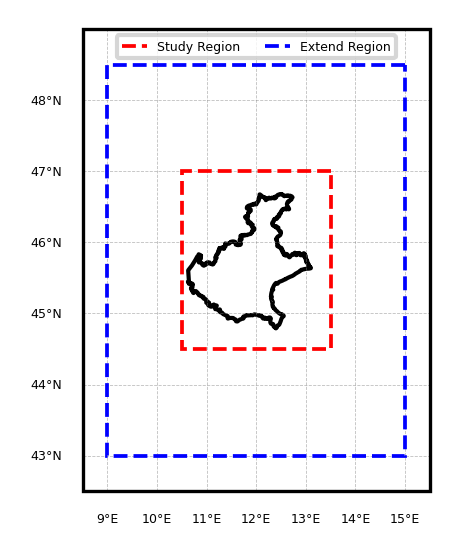

In [12]:
cmap = plt.cm.Spectral_r
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(2,2),dpi=300)
gs = gridspec.GridSpec(1,1)

# ==============================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.set_extent([lon_min-2, lon_max+2, lat_min-2, lat_max+2],crs=proj)
VENETO.plot(facecolor='None', ax=ax1)

ax1.add_patch(patches.Rectangle((lon_max,lat_max),lon_min-lon_max,lat_min-lat_max,linestyle='--',linewidth=0.9,edgecolor='r',facecolor='None',zorder=5))
ax1.add_patch(patches.Rectangle((lon_max+1.5,lat_max+1.5),(lon_min-1.5)-(lon_max+1.5),(lat_min-1.5)-(lat_max+1.5),linestyle='--',linewidth=0.9,edgecolor='b',facecolor='None',zorder=5))

gl = ax1.gridlines(crs=proj,draw_labels=True,linewidth=0.2,color='gray',alpha=0.5,linestyle='--')
gl.top_labels = False
gl.bottom_labels = True
gl.right_labels = False
gl.xlabel_style = {'size': 3, 'color': 'k'}
gl.ylabel_style = {'size': 3, 'color': 'k'}

ax1.plot([],[],linestyle='--',linewidth=0.9,color='r', label='Study Region')
ax1.plot([],[],linestyle='--',linewidth=0.9,color='b', label='Extend Region')

ax1.legend(fontsize=3,ncols=2,loc='upper center')

In [75]:
def gamma_test(DATA_in, time_reso, lat_c, lon_c, PARAM):
    if time_reso == '3h':
        PRE_daily = DATA_in.resample(time ='D').sum(dim='time', skipna=False)
        BOX = ART_pre.create_box_v2(PRE_daily, lat_c, lon_c, PARAM['npix'])
    elif time_reso == '1dy':
        BOX = ART_pre.create_box_v2(DATA_in, lat_c, lon_c, PARAM['npix'])
        PRE_daily = DATA_in
    else:
        print(f'Erorr: {time_reso} not valid')
        return None

    print(f"Neighborhood area: {BOX.sizes['lat']}x{BOX.sizes['lon']}")
    
    i_ = np.where(lats==lat_c)[0][0]
    j_ = np.where(lons==lon_c)[0][0]

    IMERG_pixel_1dy = PRE_daily['PRE'][:,i_,j_].data
    IMERG_pixel_1dy_xr = xr.DataArray(
                IMERG_pixel_1dy, 
                coords={'time':PRE_daily['time'].values}, 
                dims=('time'))

    IMERG_WEIBULL_YEAR = ART_down.fit_yearly_weibull_update(
                    IMERG_pixel_1dy_xr, 
                    thresh=PARAM['thresh'], 
                    maxmiss=PARAM['maxmiss'])
    
    vdist, vcorr = ART_pre.autocorrelation_neighborhood_v2(
                    BOX, 
                    time_reso, 
                    param['target_t'], 
                    param['thresh'])
    
    mask = ~np.isnan(vdist) & ~np.isnan(vcorr)
    vdist, vcorr = np.array(vdist)[mask], np.array(vcorr)[mask]

    vdist_sorted = np.sort(vdist) # order distance
    vcorr_sorted = vcorr[np.argsort(vdist)] # order correlation in relation to distance
    toll_cluster = 0.5

    cluster = np.zeros(len(vdist_sorted))
    count = 0
    for i in range(1, len(vdist_sorted)):
        if np.abs(vdist_sorted[i]-vdist_sorted[i-1]) < toll_cluster:
            cluster[i] = count
        else:
            count = count + 1
            cluster[i] = count

    clust = set(cluster) # Extract only the uniques values
    nclust = len(clust) # Numero de grupos

    vdist_ave = np.zeros(nclust)
    vcorr_ave = np.zeros(nclust)
    for ei, elem in enumerate(clust):
        di = vdist_sorted[cluster==elem] # Distance
        ci = vcorr_sorted[cluster==elem] # Correlation
        vdist_ave[ei] = np.mean(di) # Mean Distance
        vcorr_ave[ei] = np.mean(ci) # Mean Correlation
    
    bounds = [(0.0, 25.0),(0, 0.3)] # NEW LIMITS USING ALL CORRELATIONS FUNCTION IN VENETO

    def myfun(pardown):
        return ART_down.myfun_sse(vdist_ave, vcorr_ave, pardown, PARAM['L1'], acf=PARAM['acf'])

    resmin = differential_evolution(
                myfun,
                bounds,
                disp=True,
                tol=0.03,
                atol=0.03,
                workers=1,
                updating='deferred'
            )

    param1 = resmin.x[0]
    param2 = resmin.x[1]

    gamma = ART_down.gamma_manual(IMERG_WEIBULL_YEAR[:,0], 
                        IMERG_WEIBULL_YEAR[:,1], 
                        IMERG_WEIBULL_YEAR[:,2], 
                        PARAM['L1'], 
                        PARAM['L0'], 
                        (param1, param2), 
                        acf=PARAM['acf'])

    return gamma


In [76]:
gamma  = gamma_test(PRE_data, time_reso, lats[5], lons[5], param)

Neighborhood area: 3x3
differential_evolution step 1: f(x)= 0.0772865627415157
differential_evolution step 2: f(x)= 0.0772865627415157
differential_evolution step 3: f(x)= 0.0772865627415157
Polishing solution with 'L-BFGS-B'


0.9594726838761426

In [77]:
gamma

0.9594726838761426